In [4]:
library(forecast)
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Aggregated TS

In [5]:
df_eu  <-  read.csv(file="hts_rus_summed.csv", header=TRUE, sep=",", row.names =1 )

In [6]:
gdp_agg <- df_eu_sums <-  rowSums(df_eu)

In [7]:
gdp_agg %>% head()

2006-01-01 2006-02-01 2006-03-01 2006-04-01 2006-05-01 2006-06-01 
    -99636     -67539     -65908     -59589     -68708     -53946

In [10]:
gdp_agg  <- ts(gdp_agg, frequency = 12, start = 2006) 

In [11]:
train <- window(gdp_agg, end=c(2016,12))
test <- window(gdp_agg, start=c(2017,1))

#### Модель 0: RW with drift

The random walk with drift model is

$$Y_t=c + Y_{t-1} + Z_t$$

``rwf(y, h, drift=TRUE)``

#### Модель 1: Theta

``library(foreast)``

Equivalent to simple exponential smoothing with drift 

$\sim$ ETS(AAdN)

In [17]:
gdp_rwf <- rwf(train,h=25)
gdp_rwfwd <- rwf(train,h=25, drift=TRUE)
gdp_snaive  <- snaive(train,h=25)
gdp_theta  <- thetaf(train, h=25)
gdp_arima  <- forecast(Arima(train, order=c(2,1,2), seasonal=c(2,1,2)), h=25)
gdp_auto_arima  <- forecast(auto.arima(train), h=25)
gdp_ets <- forecast(ets(train), h=25)

In [18]:
cat("RW")
accuracy(gdp_rwf, test)[, c(2,5,7,8)]
cat("RW with drift ")
accuracy(gdp_rwfwd, test)[, c(2,5,7,8)]
cat("SNaive")
accuracy(gdp_snaive, test)[, c(2,5,7,8)]
# cat("Theta")
# accuracy(gdp_theta, test)[, c(2,5,7,8)]
cat("ARIMA")
accuracy(gdp_arima, test)[, c(2,5,7,8)]
cat("Auto ARIMA")
accuracy(gdp_auto_arima, test)[, c(2,5,7,8)]
cat("ETS")
accuracy(gdp_ets, test)[, c(2,5,7,8)]

RW

,RMSE,MAPE,ACF1,Theil's U
Training set,11531.02,469.0393,-0.1421609,NA
Test set,14204.25,141.4812,0.5640063,1.361271


RW with drift 

,RMSE,MAPE,ACF1,Theil's U
Training set,11512.12,444.34626,-0.1421609,NA
Test set,18894.72,97.12677,0.6173133,1.080711


SNaive

,RMSE,MAPE,ACF1,Theil's U
Training set,11615.18,575.7678,0.6010402,NA
Test set,17261.85,195.7287,0.6831908,1.950867


ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,5735.156,344.1934,-0.04016493,NA
Test set,16288.313,189.8155,0.68127627,2.451983


Auto ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,5867.315,308.5038,-0.04644988,NA
Test set,15320.535,179.1187,0.65623722,2.302041


ETS

,RMSE,MAPE,ACF1,Theil's U
Training set,5638.747,148.3019,0.1408629,NA
Test set,10980.156,106.1166,0.5549177,1.544246


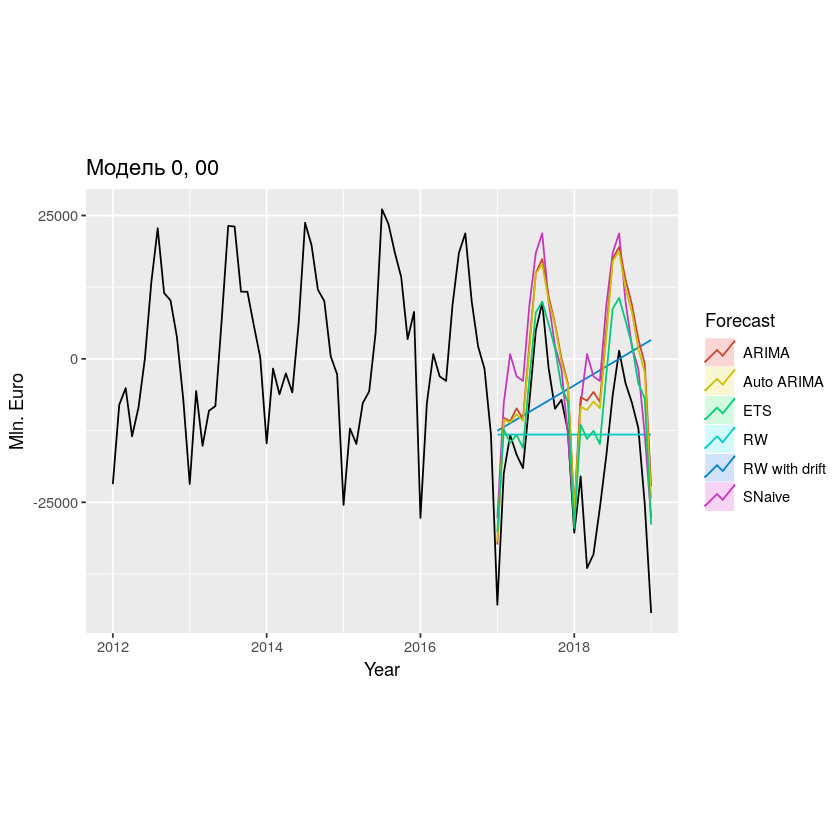

In [19]:
autoplot(window(gdp_agg, start=2012)) +
    autolayer(gdp_rwf, series="RW", PI=FALSE) +
    autolayer(gdp_rwfwd, series="RW with drift", PI=FALSE) +
    autolayer(gdp_snaive, series="SNaive", PI=FALSE) +
#     autolayer(gdp_theta, series="Theta Method", PI=FALSE) +
    autolayer(gdp_arima, series="ARIMA", PI=FALSE) +
    autolayer(gdp_auto_arima, series="Auto ARIMA", PI=FALSE) +
    autolayer(gdp_ets, series="ETS", PI=FALSE) +
    xlab("Year") + ylab("Mln. Euro") +
    ggtitle("Модель 0, 00") +
    guides(colour=guide_legend(title="Forecast")) +
    theme(aspect.ratio = 0.75)

### strucchange

In [20]:
library(strucchange)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich



	 Optimal 2-segment partition: 

Call:
breakpoints.Fstats(obj = fs.gdp_agg)

Breakpoints at observation number:
83 

Corresponding to breakdates:
2012(11) 

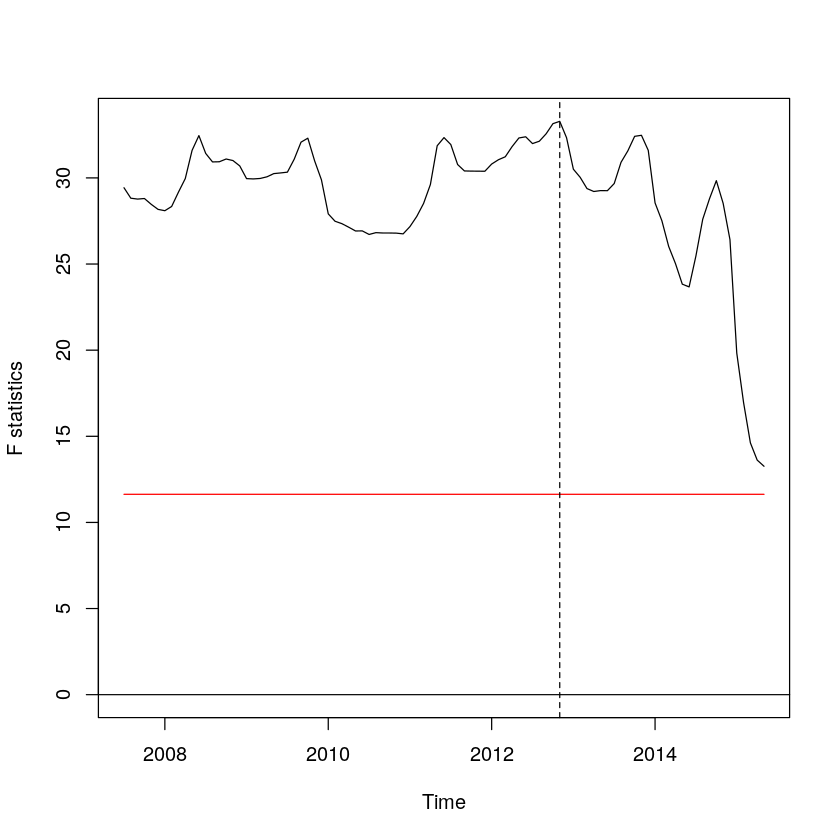

In [21]:
## F statistics indicate one breakpoint
fs.gdp_agg <- Fstats(train  ~  1 + time(train))
plot(fs.gdp_agg)
breakpoints(fs.gdp_agg)
lines(breakpoints(fs.gdp_agg))

In [22]:
breakpoints(fs.gdp_agg)[[1]] 

[1] 83

In [23]:
dum  <-  rep(c(0,1), c(breakpoints(fs.gdp_agg)[[1]], length(gdp_agg) - breakpoints(fs.gdp_agg)[[1]]))
dum2  <-  rep(c(0,1), c(36,length(gdp_agg)-36))

In [24]:
all(dum == dum2)

[1] FALSE

https://www.stat.ncsu.edu/people/bloomfield/courses/st730/slides/R-comments.pdf

In [25]:
library(zoo)

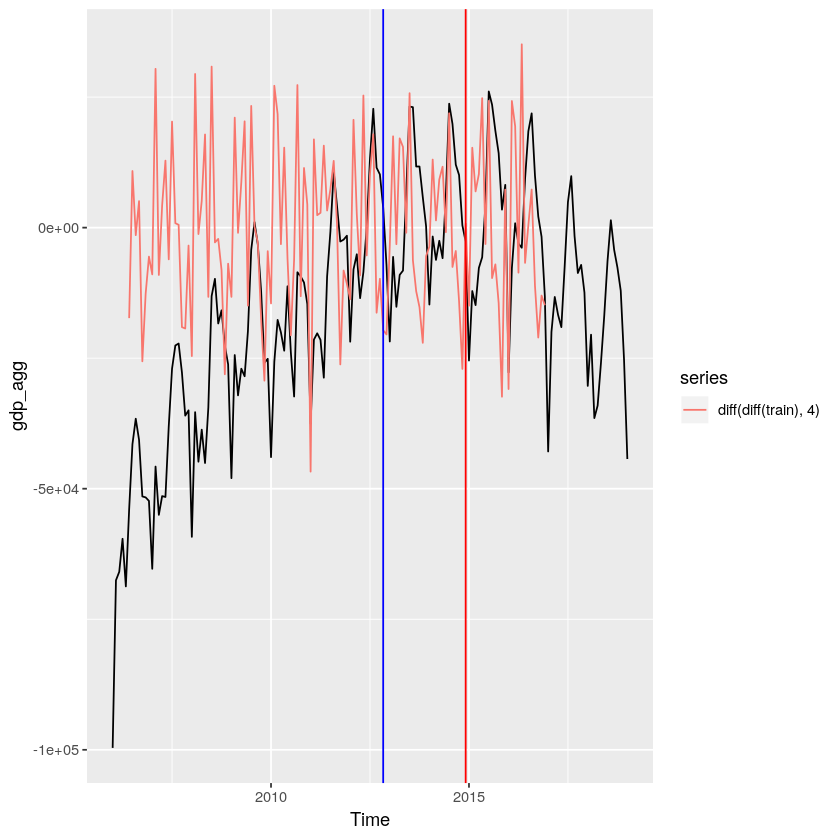

In [38]:
autoplot(gdp_agg) +
    autolayer(diff(diff(train),4)) + 
    geom_vline(xintercept=c(time(gdp_agg)[breakpoints(fs.gdp_agg)[[1]]],time(gdp_agg)[108]), col=c("blue", "red"))

In [27]:
auto.arima(gdp_agg, xreg=dum)

Series: gdp_agg 
Regression with ARIMA(2,1,2)(0,1,1)[12] errors 

Coefficients:
          ar1     ar2     ma1      ma2     sma1       xreg
      -0.3328  0.1575  0.0810  -0.6005  -0.7716  -4887.482
s.e.   0.1580  0.1402  0.1292   0.1166   0.0868   4952.328

sigma^2 estimated as 37493180:  log likelihood=-1462.68
AIC=2939.36   AICc=2940.18   BIC=2960.15

In [28]:
auto.arima(train)
auto.arima(train,  xreg=dum[1:132])
# auto.arima(train, lambda = 'auto', xreg=dum2[1:68])

Series: train 
ARIMA(0,1,2)(0,1,1)[12] 

Coefficients:
          ma1      ma2     sma1
      -0.3092  -0.3235  -0.7914
s.e.   0.1009   0.1063   0.1126

sigma^2 estimated as 39173718:  log likelihood=-1213.72
AIC=2435.45   AICc=2435.8   BIC=2446.56

Series: train 
Regression with ARIMA(0,1,2)(0,1,1)[12] errors 

Coefficients:
        ma1      ma2     sma1       xreg
      -0.31  -0.3177  -0.7990  -6164.050
s.e.   0.10   0.1038   0.1162   5055.462

sigma^2 estimated as 38899304:  log likelihood=-1212.97
AIC=2435.94   AICc=2436.47   BIC=2449.84

In [34]:
gdp_rwfwd <- rwf(train,h=25, drift=TRUE)
gdp_snaive  <- snaive(train,h=25)
# gdp_theta  <- thetaf(train, h=25)
gdp_arima  <- forecast(Arima(train, order=c(2,1,2), seasonal=c(2,1,2)), h=25)
gdp_auto_arima  <- forecast(auto.arima(train), h=25)
gdp_str_arima  <- forecast(auto.arima(train, xreg=dum[1:132]), 7, xreg = dum[133:157])
# gdp_str2_arima  <-  forecast(auto.arima(train, lambda = 'auto', xreg=dum[1:132]), 7, xreg = dum2[69:75])
gdp_str3_arima  <- forecast(Arima(train, order=c(2,1,2), seasonal=c(2,1,2), xreg=dum[1:132]), h=25,  xreg = dum[133:157])

cat("RW with drift ")
accuracy(gdp_rwfwd, test)[, c(2,5,7,8)]
# cat("Theta")
# accuracy(gdp_theta, test)[, c(2,5,7,8)]
cat("ARIMA")
accuracy(gdp_arima, test)[, c(2,5,7,8)]
cat("ARIMA 2009")
accuracy(gdp_str3_arima, test)[, c(2,5,7,8)]
cat("Auto ARIMA")
accuracy(gdp_auto_arima, test)[, c(2,5,7,8)]
cat("Auto ARIMA str")
accuracy(gdp_str_arima, test)[, c(2,5,7,8)]
# cat("Auto ARIMA 2009")
# accuracy(gdp_str2_arima, test)[, c(2,5,7,8)]


Warning message in forecast.Arima(Arima(train, order = c(2, 1, 2), seasonal = c(2, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”

RW with drift 

,RMSE,MAPE,ACF1,Theil's U
Training set,11512.12,444.34626,-0.1421609,NA
Test set,18894.72,97.12677,0.6173133,1.080711


ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,5735.156,344.1934,-0.04016493,NA
Test set,16288.313,189.8155,0.68127627,2.451983


ARIMA 2009

,RMSE,MAPE,ACF1,Theil's U
Training set,5673.748,347.1516,-0.03403805,NA
Test set,17325.767,201.3045,0.70231995,2.62207


Auto ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,5867.315,308.5038,-0.04644988,NA
Test set,15320.535,179.1187,0.65623722,2.302041


Auto ARIMA str

,RMSE,MAPE,ACF1,Theil's U
Training set,5821.473,309.0577,-0.03881626,NA
Test set,16311.831,190.5549,0.67526038,2.451726


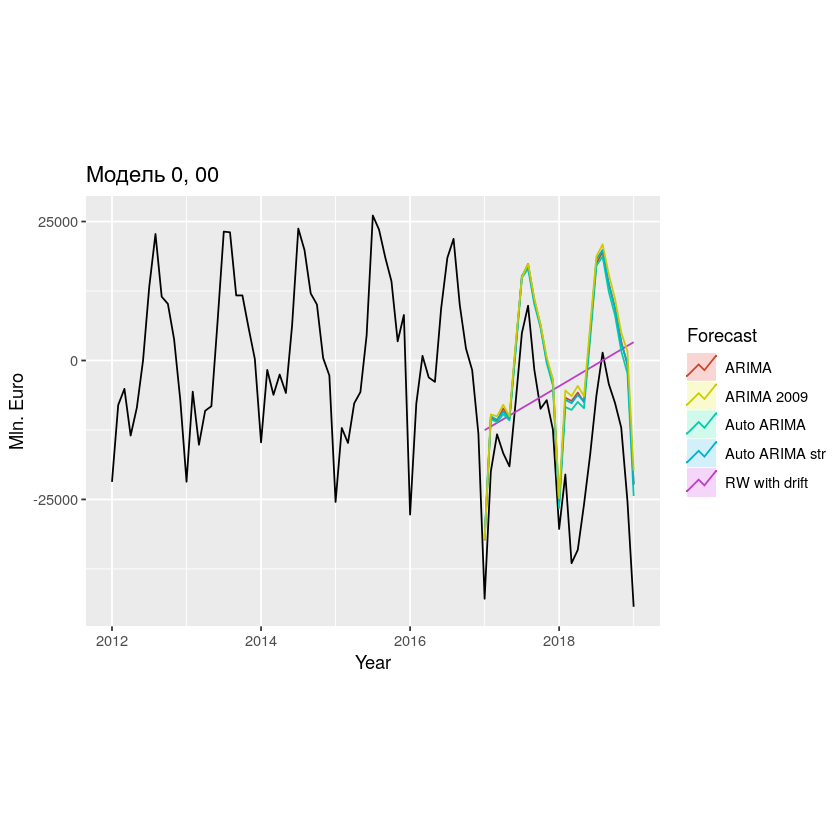

In [35]:
autoplot(window(gdp_agg, start=2012)) +
    autolayer(gdp_rwfwd, series="RW with drift", PI=FALSE) +
    autolayer(gdp_arima, series="ARIMA", PI=FALSE) +
    autolayer(gdp_auto_arima, series="Auto ARIMA", PI=FALSE) +
    autolayer(gdp_str_arima, series="Auto ARIMA str", PI=FALSE) +
#     autolayer(gdp_str2_arima, series="Auto ARIMA 2009", PI=FALSE) +
    autolayer(gdp_str3_arima, series="ARIMA 2009", PI=FALSE) +
    xlab("Year") + ylab("Mln. Euro") +
    ggtitle("Модель 0, 00") +
    guides(colour=guide_legend(title="Forecast")) +
    theme(aspect.ratio = 0.75)

In [40]:
length(time(train))

[1] 132


	 Optimal 2-segment partition: 

Call:
breakpoints.Fstats(obj = fs.gdp_agg)

Breakpoints at observation number:
54 

Corresponding to breakdates:
2011(6) 

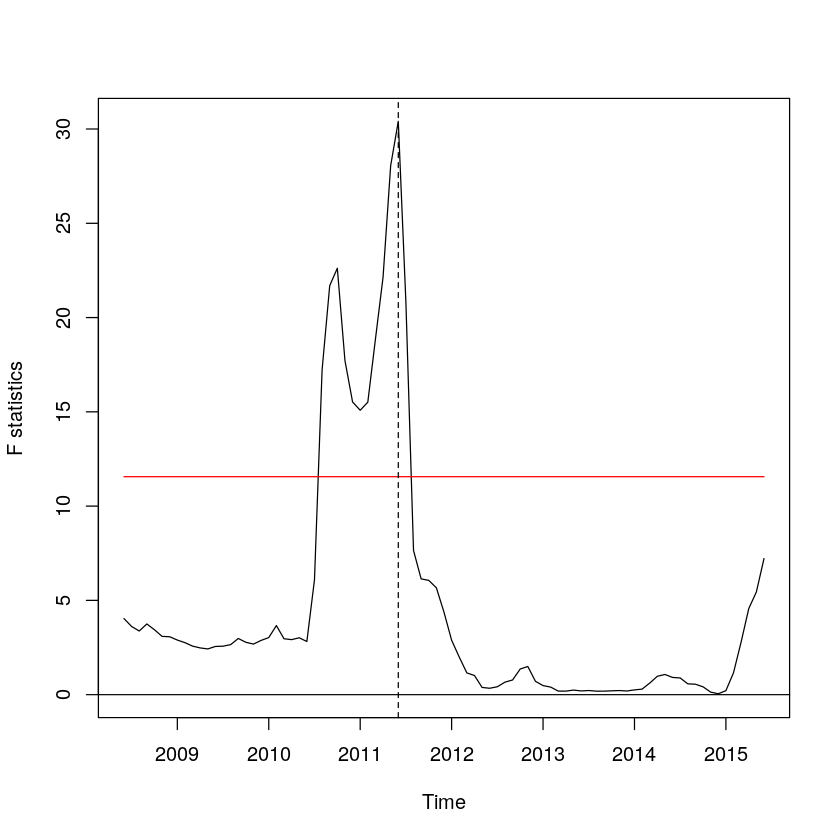

In [42]:
## F statistics indicate one breakpoint
fs.gdp_agg <- Fstats(diff(train,12)  ~  1 + time(train)[1:120])
plot(fs.gdp_agg)
breakpoints(fs.gdp_agg)
lines(breakpoints(fs.gdp_agg))